In [2]:
import pandas as pd 
import numpy as np 
import requests
import json
import matplotlib.pyplot as plt
import datetime
import os
import re

%matplotlib inline

In [3]:
# Twitter archive data frame
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
# imagie predictions data frame
df_imagie_predictions= pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv',sep='\t')

In [4]:
df_archive.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [5]:
df_imagie_predictions.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
request = requests.get(url)
file_name = url.split('/')[-1]
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(request.content)

In [ ]:
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
 Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [7]:
df_list_dict = []

with open('tweet-json.txt', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favourite_count = tweet['favorite_count']
        df_list_dict.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favourite_count': favourite_count})
        
df_api_twitter = pd.DataFrame(df_list_dict)

In [8]:
df_api_twitter.head(10)

,tweet_id,retweet_count,favourite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [9]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
df_imagie_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
df_api_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2354 non-null   int64
 1   retweet_count    2354 non-null   int64
 2   favourite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [12]:
(df_archive.loc[: , 'doggo':'puppo']!= 'None').sum()

doggo       97
floofer     10
pupper     257
puppo       30
dtype: int64

In [13]:
non_unique_bread = df_archive[(df_archive['doggo'] != 'None') & (df_archive['pupper'] != 'None')]
non_unique_bread.iloc[:, -4:]

,doggo,floofer,pupper,puppo
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None
733,doggo,None,pupper,None
778,doggo,None,pupper,None
822,doggo,None,pupper,None
889,doggo,None,pupper,None
956,doggo,None,pupper,None


In [14]:
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

### quality issue
## archive: 
        timestamp object type
        doggo,floofer,pupperand puppo columns wrong description Nan value
        name row wrong names as a , an etc
        missing value in expanded_urls column
        rating_denominator wrong values 
        retweets and replies
        tweet id int type
       
## imagie prediction:
                            small letters and capital letters in p1,p2,p3
                            tweet id int type
## Twitter api:
                  tweet id int type


### Tidness issue 
## archive:
       doggo,floofer,pupperand puppo are values not variables
       the columns 'retweeted_status_id' 'retweeted_status_user_id'  'retweeted_status_timestamp' 'in_reply_to_status_id'
       and'in_reply_to_user_id' has no observation after we get rid of retewwts and replies
### df_api_twitter:
               has no new observation so it shouldn't be a table

## clean
# define
 convert timestampe object type to datatime type

## code

In [16]:
df_archive_clean = df_archive.copy()
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

# Test

In [17]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

# define
missing value in expanded url dropped

# code

In [18]:
df_archive_clean = df_archive_clean[df_archive_clean['expanded_urls'] != ""]

## Test

In [19]:
df_archive_clean[df_archive_clean['expanded_urls'] == ""]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [20]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

## define
name,doggo,floofer,pupper and puppo columns make none value into nan

## code

In [21]:
df_archive_clean.iloc[:, -4:  ] = df_archive_clean.iloc[:, -4:  ].replace('None','')


## Test

In [22]:
df_archive_clean['doggo'].head(5)

0    
1    
2    
3    
4    
Name: doggo, dtype: object

In [23]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### define 
## Tidness issue
doggo,floofer,pupperand puppo columns merg into one column 

## Code

In [24]:
df_archive_clean['dog_breed'] = df_archive_clean.doggo + df_archive_clean.floofer + df_archive_clean.pupper + df_archive_clean.puppo
df_archive_clean =df_archive_clean.drop(columns=['doggo','floofer','pupper','puppo'])

## Test

In [25]:
df_archive_clean['dog_breed'].head(20)

0          
1          
2          
3          
4          
5          
6          
7          
8          
9     doggo
10         
11         
12    puppo
13         
14    puppo
15         
16         
17         
18         
19         
Name: dog_breed, dtype: object

In [26]:
df_archive_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [27]:
df_archive_clean['dog_breed']=df_archive_clean.dog_breed.replace('',np.nan)

In [28]:
df_archive_clean.dog_breed.value_counts(dropna=False)

NaN             1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_breed, dtype: int64

### Quality issue
## removing retweets and replies
removing retweets and replies using compersion with image-prediction data frame

## code

In [29]:
df_imagie_predictions_clean = df_imagie_predictions.copy()

In [30]:
image_prediction_id_tweets_lst_unique = list(df_imagie_predictions_clean.tweet_id.unique())

In [31]:
len(image_prediction_id_tweets_lst_unique) == df_archive_clean.tweet_id.isin(image_prediction_id_tweets_lst_unique).sum()

True

In [32]:
df_archive_clean = df_archive_clean[df_archive_clean.tweet_id.isin(image_prediction_id_tweets_lst_unique)]

In [33]:
retweet_data = df_archive_clean.retweeted_status_id.notnull()

In [34]:
df_archive_clean[retweet_data].shape[0]

81

In [35]:
df_archive_clean = df_archive_clean[~retweet_data]

In [36]:
replies_data = df_archive_clean.in_reply_to_status_id.notnull()

In [37]:
df_archive_clean[replies_data].shape[0]

23

In [38]:
df_archive_clean = df_archive_clean[~replies_data]

In [39]:
np.logical_not(df_imagie_predictions_clean.tweet_id.isin(list(df_archive_clean.tweet_id)))

0       False
1       False
2       False
3       False
4       False
        ...  
2070    False
2071    False
2072    False
2073    False
2074    False
Name: tweet_id, Length: 2075, dtype: bool

In [40]:
df_imagie_predictions_clean=df_imagie_predictions_clean[~np.logical_not(df_imagie_predictions_clean.tweet_id.isin(list(df_archive_clean.tweet_id)))]

In [41]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [42]:
df_imagie_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   int64  
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


### Quality
## define
rating_denominator wrong values changed using images 

## code

In [43]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['rating_denominator'] != 10 ].text

433                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
902                                                                                                Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068                                 After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1120                                                    Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165                                                                                                          

In [44]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['rating_denominator'] == 11 ].text

1068    After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1662     This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Name: text, dtype: object

In [45]:
 df_archive_clean.loc[1068,'rating_denominator'] =10

In [46]:
 df_archive_clean.loc[1662,'rating_denominator'] =10

In [47]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [48]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['rating_denominator'] == 20 ].text

1165    Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
Name: text, dtype: object

In [49]:
 df_archive_clean.loc[1165,'rating_denominator'] =10

In [50]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [51]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['rating_denominator'] == 2 ].text

2335    This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Name: text, dtype: object

In [52]:
 df_archive_clean.loc[2335,'rating_denominator'] =10

In [53]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [54]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['rating_denominator'] == 7 ].text

516    Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Name: text, dtype: object

In [55]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [56]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['rating_denominator'] == 50 ].text

1202                                 This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
1274    From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
1351                                                                    Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
Name: text, dtype: object

In [57]:
 df_archive_clean.loc[1202,'rating_denominator'] =10
    

In [58]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [59]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

## Test

In [60]:
df_archive_clean.rating_denominator.value_counts()

10     1959
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
7         1
Name: rating_denominator, dtype: int64

In [61]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

### Quality issue
## define
name row wrong names as a , an etc drop it or correct it 

In [62]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['name'] == 'a' ].text

56      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
649                                Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
801                    Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
1002                   This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
1004                     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
1017                         This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2
1049            

In [63]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [64]:
pd.set_option('display.max_colwidth', None)
df_archive_clean[df_archive_clean['name'] == 'an' ].text

1025     This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt
1362                  This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR
2204    This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg
2333    This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL
2335       This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
2349     This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc
Name: text, dtype: object

In [65]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [66]:
regax_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')

In [67]:
for index, row in df_archive_clean.iterrows():  
    try:
        if row['name'] == "a":
            d_name = re.findall(regax_2, row['text'])[0]
            df_archive_clean.loc[index,'name'] = df_archive_clean.loc[index,'name'].replace('a', d_name)
        elif row['name'] == 'an':
            d_name = re.findall(regax_2, row['text'])[0]
            df_archive_clean.loc[index,'name'] = df_archive_clean.loc[index,'name'].replace('an', d_name)
    except IndexError:
        df_archive_clean.loc[index,'name'] = np.nan

## Test

In [68]:
 df_archive_clean.loc[2348,'name']

nan

In [69]:
df_archive_clean.loc[2311,'name']

'Octaviath'

In [70]:
df_archive_clean.loc[2304,'name']

'Pepe'

In [71]:
df_archive_clean.loc[2287,'name']

'Daryl'

In [72]:
df_archive_clean.loc[1853,'name']

'Wylie'

In [73]:
df_archive_clean[df_archive_clean['name'] == 'a']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_breed


In [74]:
df_archive_clean[df_archive_clean['name'] == 'an']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_breed


In [75]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1971 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1971 non-null   datetime64[ns, UTC]
 4   source                      1971 non-null   object             
 5   text                        1971 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1971 non-null   object             
 10  rating_numerator            1971 non-null   int64           

In [76]:
df_imagie_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   int64  
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


In [77]:
df_archive_clean = df_archive_clean.reset_index()

In [78]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   index                       1971 non-null   int64              
 1   tweet_id                    1971 non-null   int64              
 2   in_reply_to_status_id       0 non-null      float64            
 3   in_reply_to_user_id         0 non-null      float64            
 4   timestamp                   1971 non-null   datetime64[ns, UTC]
 5   source                      1971 non-null   object             
 6   text                        1971 non-null   object             
 7   retweeted_status_id         0 non-null      float64            
 8   retweeted_status_user_id    0 non-null      float64            
 9   retweeted_status_timestamp  0 non-null      object             
 10  expanded_urls               1971 non-null   object          

### Tidenees issue
## define
the columns 'retweeted_status_id' 'retweeted_status_user_id'  'retweeted_status_timestamp' 'in_reply_to_status_id' and         'in_reply_to_user_id' has no observation after we get rid of retewwts and replies

## code

In [79]:
df_archive_clean=df_archive_clean.drop(columns=['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'])

## Test

In [80]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   index               1971 non-null   int64              
 1   tweet_id            1971 non-null   int64              
 2   timestamp           1971 non-null   datetime64[ns, UTC]
 3   source              1971 non-null   object             
 4   text                1971 non-null   object             
 5   expanded_urls       1971 non-null   object             
 6   rating_numerator    1971 non-null   int64              
 7   rating_denominator  1971 non-null   int64              
 8   name                1931 non-null   object             
 9   dog_breed           303 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 154.1+ KB


In [81]:
df_imagie_predictions_clean = df_imagie_predictions_clean.reset_index()

In [82]:
df_imagie_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1971 non-null   int64  
 1   tweet_id  1971 non-null   int64  
 2   jpg_url   1971 non-null   object 
 3   img_num   1971 non-null   int64  
 4   p1        1971 non-null   object 
 5   p1_conf   1971 non-null   float64
 6   p1_dog    1971 non-null   bool   
 7   p2        1971 non-null   object 
 8   p2_conf   1971 non-null   float64
 9   p2_dog    1971 non-null   bool   
 10  p3        1971 non-null   object 
 11  p3_conf   1971 non-null   float64
 12  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(3), object(4)
memory usage: 159.9+ KB


### Quality issue
## define
tweet id int type converting it into object type

## code

In [83]:
df_archive_clean.tweet_id = df_archive_clean.tweet_id.astype(str)
df_imagie_predictions_clean.tweet_id  = df_imagie_predictions_clean.tweet_id.astype(str)
df_api_twitter_clean = df_api_twitter.copy()
df_api_twitter_clean.tweet_id = df_api_twitter_clean.tweet_id.astype(str) 

## Test

In [84]:
 df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   index               1971 non-null   int64              
 1   tweet_id            1971 non-null   object             
 2   timestamp           1971 non-null   datetime64[ns, UTC]
 3   source              1971 non-null   object             
 4   text                1971 non-null   object             
 5   expanded_urls       1971 non-null   object             
 6   rating_numerator    1971 non-null   int64              
 7   rating_denominator  1971 non-null   int64              
 8   name                1931 non-null   object             
 9   dog_breed           303 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(6)
memory usage: 154.1+ KB


In [85]:
df_imagie_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1971 non-null   int64  
 1   tweet_id  1971 non-null   object 
 2   jpg_url   1971 non-null   object 
 3   img_num   1971 non-null   int64  
 4   p1        1971 non-null   object 
 5   p1_conf   1971 non-null   float64
 6   p1_dog    1971 non-null   bool   
 7   p2        1971 non-null   object 
 8   p2_conf   1971 non-null   float64
 9   p2_dog    1971 non-null   bool   
 10  p3        1971 non-null   object 
 11  p3_conf   1971 non-null   float64
 12  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(5)
memory usage: 159.9+ KB


In [86]:
df_api_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2354 non-null   object
 1   retweet_count    2354 non-null   int64 
 2   favourite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


### quality
## define
small letters and capital letters in p1,p2,p3 using captalize method 

## code

In [87]:
df_imagie_predictions_clean['p1'] = df_imagie_predictions_clean.p1.str.capitalize()

In [88]:
df_imagie_predictions_clean['p2'] = df_imagie_predictions_clean.p2.str.capitalize()

In [89]:
df_imagie_predictions_clean['p3'] = df_imagie_predictions_clean.p3.str.capitalize()

## Test

In [90]:
df_imagie_predictions_clean['p1']

0       Welsh_springer_spaniel
1                      Redbone
2              German_shepherd
3          Rhodesian_ridgeback
4           Miniature_pinscher
                 ...          
1966                    Basset
1967               Paper_towel
1968                 Chihuahua
1969                 Chihuahua
1970                    Orange
Name: p1, Length: 1971, dtype: object

In [91]:
df_imagie_predictions_clean['p2']

0                   Collie
1       Miniature_pinscher
2                 Malinois
3                  Redbone
4               Rottweiler
               ...        
1966      English_springer
1967    Labrador_retriever
1968              Malamute
1969              Pekinese
1970                 Bagel
Name: p2, Length: 1971, dtype: object

In [92]:
df_imagie_predictions_clean['p3']

0                 Shetland_sheepdog
1               Rhodesian_ridgeback
2                        Bloodhound
3                Miniature_pinscher
4                          Doberman
                   ...             
1966    German_short-haired_pointer
1967                        Spatula
1968                         Kelpie
1969                       Papillon
1970                         Banana
Name: p3, Length: 1971, dtype: object

In [93]:
df_imagie_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1971 non-null   int64  
 1   tweet_id  1971 non-null   object 
 2   jpg_url   1971 non-null   object 
 3   img_num   1971 non-null   int64  
 4   p1        1971 non-null   object 
 5   p1_conf   1971 non-null   float64
 6   p1_dog    1971 non-null   bool   
 7   p2        1971 non-null   object 
 8   p2_conf   1971 non-null   float64
 9   p2_dog    1971 non-null   bool   
 10  p3        1971 non-null   object 
 11  p3_conf   1971 non-null   float64
 12  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(5)
memory usage: 159.9+ KB


In [94]:
 df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   index               1971 non-null   int64              
 1   tweet_id            1971 non-null   object             
 2   timestamp           1971 non-null   datetime64[ns, UTC]
 3   source              1971 non-null   object             
 4   text                1971 non-null   object             
 5   expanded_urls       1971 non-null   object             
 6   rating_numerator    1971 non-null   int64              
 7   rating_denominator  1971 non-null   int64              
 8   name                1931 non-null   object             
 9   dog_breed           303 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(6)
memory usage: 154.1+ KB


In [95]:
df_api_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2354 non-null   object
 1   retweet_count    2354 non-null   int64 
 2   favourite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


In [96]:
 df_archive_clean

,index,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed
0,0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
1,1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN
2,2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN
3,3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN
4,4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...,...
1966,2351,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,NaN
1967,2352,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,NaN,NaN
1968,2353,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,NaN,NaN
1969,2354,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,NaN,NaN


### Tidness
## define
api twitter data frame has no new observation so it shouldn't be a table 

## code

In [97]:
 archive_clean_id_tweets_lst = list( df_archive_clean.tweet_id.unique())

In [98]:
len(archive_clean_id_tweets_lst) == df_api_twitter_clean.tweet_id.isin(archive_clean_id_tweets_lst).sum()

True

In [99]:
df_api_twitter_clean = df_api_twitter_clean[df_api_twitter_clean.tweet_id.isin(archive_clean_id_tweets_lst)]

In [100]:
df_archive_master=pd.merge(df_api_twitter_clean, df_archive_clean, on="tweet_id", how="left")

## Test

In [101]:
df_api_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1971 non-null   object
 1   retweet_count    1971 non-null   int64 
 2   favourite_count  1971 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.6+ KB


In [102]:
df_api_twitter_clean =df_api_twitter_clean.reset_index()

In [103]:
df_api_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            1971 non-null   int64 
 1   tweet_id         1971 non-null   object
 2   retweet_count    1971 non-null   int64 
 3   favourite_count  1971 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 61.7+ KB


In [104]:
df_api_twitter_clean = df_api_twitter_clean.drop(columns='index')

In [105]:
df_api_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1971 non-null   object
 1   retweet_count    1971 non-null   int64 
 2   favourite_count  1971 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.3+ KB


In [106]:
df_archive_clean = df_archive_clean.drop(columns='index')

In [107]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   name                1931 non-null   object             
 8   dog_breed           303 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 138.7+ KB


In [108]:
df_archive_master=pd.merge(df_api_twitter_clean, df_archive_clean, on="tweet_id", how="left")

In [109]:
df_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   retweet_count       1971 non-null   int64              
 2   favourite_count     1971 non-null   int64              
 3   timestamp           1971 non-null   datetime64[ns, UTC]
 4   source              1971 non-null   object             
 5   text                1971 non-null   object             
 6   expanded_urls       1971 non-null   object             
 7   rating_numerator    1971 non-null   int64              
 8   rating_denominator  1971 non-null   int64              
 9   name                1931 non-null   object             
 10  dog_breed           303 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(4), object(6)
memory usage: 184.8+ KB


In [110]:
df_imagie_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1971 non-null   int64  
 1   tweet_id  1971 non-null   object 
 2   jpg_url   1971 non-null   object 
 3   img_num   1971 non-null   int64  
 4   p1        1971 non-null   object 
 5   p1_conf   1971 non-null   float64
 6   p1_dog    1971 non-null   bool   
 7   p2        1971 non-null   object 
 8   p2_conf   1971 non-null   float64
 9   p2_dog    1971 non-null   bool   
 10  p3        1971 non-null   object 
 11  p3_conf   1971 non-null   float64
 12  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(5)
memory usage: 159.9+ KB


In [111]:
df_imagie_predictions_clean = df_imagie_predictions_clean.drop(columns='index')

In [112]:
df_imagie_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   object 
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 144.5+ KB


In [113]:
df_archive_master.to_csv('twitter_archive_master.csv', index=False)
df_imagie_predictions_clean.to_csv('image_predictions_clean.csv',index=False)

### Analysis

## code

In [114]:
df_archive_master.describe()

,retweet_count,favourite_count,rating_numerator,rating_denominator
count,1971.000000,1971.000000,1971.000000,1971.000000
mean,2784.449518,8949.106545,12.223237,10.455099
std,4697.662893,12267.799790,41.634034,6.789092
min,16.000000,81.000000,0.000000,7.000000
25%,628.500000,1997.000000,10.000000,10.000000
50%,1367.000000,4147.000000,11.000000,10.000000
75%,3239.000000,11402.500000,12.000000,10.000000
max,79515.000000,132810.000000,1776.000000,170.000000


In [115]:
df_archive_master.retweet_count.count()

1971

In [116]:
df_archive_master.groupby(['rating_denominator','rating_numerator'])['favourite_count'].mean()

rating_denominator  rating_numerator
7                   24                   5927.000000
10                  0                   24574.000000
                    1                    5599.800000
                    2                    2256.777778
                    3                    2395.526316
                    4                    2842.937500
                    5                    3950.424242
                    6                    2716.968750
                    7                    3462.173077
                    8                    2450.905263
                    9                    2536.560000
                    10                   4141.103118
                    11                   6919.831633
                    12                  11343.114350
                    13                  23229.588933
                    14                  29950.939394
                    26                   1879.000000
                    27                   7320.000000
         

In [117]:
df_archive_master.groupby('dog_breed')['rating_numerator'].mean()

dog_breed
doggo           11.888889
doggofloofer    11.000000
doggopupper     11.000000
doggopuppo      13.000000
floofer         12.000000
pupper          10.716418
puppo           12.000000
Name: rating_numerator, dtype: float64

In [118]:
df_archive_master.groupby('dog_breed')['rating_numerator'].count()

dog_breed
doggo            63
doggofloofer      1
doggopupper       8
doggopuppo        1
floofer           7
pupper          201
puppo            22
Name: rating_numerator, dtype: int64

In [134]:
df_archive_master.groupby('dog_breed')['tweet_id'].sum()

dog_breed
doggo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [129]:
df_archive_master.groupby('dog_breed')['rating_numerator'].sum()

dog_breed
doggo            749
doggofloofer      11
doggopupper       88
doggopuppo        13
floofer           84
pupper          2154
puppo            264
Name: rating_numerator, dtype: int64

In [119]:
df_archive_master.groupby('dog_breed')['retweet_count'].sum()

dog_breed
doggo           448919
doggofloofer      3433
doggopupper      35178
doggopuppo       19196
floofer          34781
pupper          478883
puppo           142427
Name: retweet_count, dtype: int64

In [132]:
df_archive_master.groupby('rating_numerator')['retweet_count'].count()

rating_numerator
0         1
1         5
2         9
3        19
4        16
5        33
6        32
7        52
8        95
9       150
10      417
11      392
12      446
13      253
14       33
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
420       1
1776      1
Name: retweet_count, dtype: int64

In [120]:
df_archive_master.groupby('dog_breed')['favourite_count'].sum()

dog_breed
doggo           1219452
doggofloofer      17169
doggopupper      105759
doggopuppo        47844
floofer           92442
pupper          1457356
puppo            474806
Name: favourite_count, dtype: int64

In [121]:
df_imagie_predictions_clean.mean()

tweet_id         inf
img_num     1.201928
p1_conf     0.594558
p1_dog      0.742263
p2_conf     0.134585
p2_dog      0.750888
p3_conf     0.060166
p3_dog      0.726027
dtype: float64

In [122]:
df_archive_master.mean()

tweet_id                      inf
retweet_count         2784.449518
favourite_count       8949.106545
rating_numerator        12.223237
rating_denominator      10.455099
dtype: float64

In [123]:
df_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   retweet_count       1971 non-null   int64              
 2   favourite_count     1971 non-null   int64              
 3   timestamp           1971 non-null   datetime64[ns, UTC]
 4   source              1971 non-null   object             
 5   text                1971 non-null   object             
 6   expanded_urls       1971 non-null   object             
 7   rating_numerator    1971 non-null   int64              
 8   rating_denominator  1971 non-null   int64              
 9   name                1931 non-null   object             
 10  dog_breed           303 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(4), object(6)
memory usage: 184.8+ KB


In [124]:
rating_numerator_sorted = np.sort(df_archive_master.rating_numerator.unique())

In [125]:
rating_denominator_sorted = np.sort(df_archive_master.rating_denominator.unique())

Text(0, 0.5, 'tweets likes numbers')

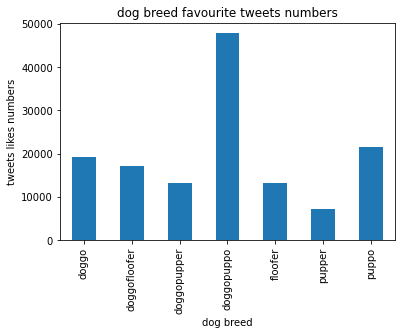

In [126]:
df_archive_master.groupby(['dog_breed'])['favourite_count'].mean().plot.bar(stacked=True)
plt.title('dog breed favourite tweets numbers')
plt.xlabel('dog breed')
plt.ylabel('tweets likes numbers')

Text(0, 0.5, 'rating numerator')

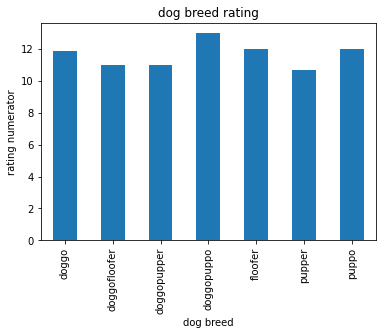

In [127]:
df_archive_master.groupby(['dog_breed'])['rating_numerator'].mean().plot.bar(stacked=True)
plt.title('dog breed rating')
plt.xlabel('dog breed')
plt.ylabel('rating numerator')

In [128]:
df_archive_master.groupby('rating_numerator')['favourite_count','retweet_count'].sum()

<ipython-input-128-2f337755d37f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_archive_master.groupby('rating_numerator')['favourite_count','retweet_count'].sum()


,favourite_count,retweet_count
rating_numerator,,
0,24574,3443
1,27999,12561
2,20311,12153
3,45515,18099
4,45487,18349
5,130364,44015
6,86943,33396
7,180033,69317
8,232836,85947


### Insights

The average rating of numerator is 11 and the rating frequency become smaller with high rating

ratings with 12,13 and 14 gets high retweet count and most likes

pupper images tweets the most although pupper also gets the lowest favorite counts and retweet counts and rating.